## Četvrti zadatak
<hr>

Automatsko numerisanje jednačina

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

Importi

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import as_strided
import time
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from IPython.core.display import HTML
from IPython.display import clear_output

%matplotlib inline

HTML centriranje plotova

In [3]:
out = display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

### Funkcije
Pomoćne funkcije korišćene u zadatku.

Prostorni kernel Gausovog filtra

\begin{equation} \label{gauss_nf}
w(x, y) = \frac{e^{-\displaystyle\frac{D^2(x, y)}{2\sigma_s^2}}}{\sum_{i=-r}^r \sum_{j=-r}^r w(i, j)}
\end{equation}

$$
x, y \in [-r, r]
$$

gde su $(x, y)$ prostorne koordinate u kernelu $w$, $r$ radijus filtra, $D^2(x, y)$ kvadrat euklidskog rastojanja pozicije $(x, y)$ od koordinatnog početka dato formulom (\ref{euclid_distance}), a $\sigma_s$ standardna devijacije Gausove funkcije.

In [4]:
def spatial_kernel(r, sigma_s):
    A = np.arange(-r, r + 1)
    A = np.einsum("i,i->i", A, A)
    kernel = np.exp(-(np.tile(A, (2 * r + 1, 1)) + np.tile(A, (2 * r + 1, 1)).T) / (2 * sigma_s ** 2))
    return kernel / np.sum(kernel)

Matrica lokalnih susedstava kao u drugom zadatku

In [5]:
def make_4d_array(arr_padded, r):
    N = arr_padded.shape[0] - 2 * r
    M = arr_padded.shape[1] - 2 * r

    # vracamo view na niz, samo ne kapiram zasto puta 2 strides
    return as_strided(arr_padded, shape=(N, M, 2 * r + 1, 2 * r + 1), strides=arr_padded.strides * 2)

Isto kao i gore samo prepravljeno za kernele proizvoljnih dimenzija.

In [6]:
def make_4d_array_custom(arr_padded, N, M, a, b):
    
    return as_strided(arr_padded, shape=(N, M, a, b), strides=arr_padded.strides * 2)

Gausov filtar implementiran u prostornom domenu sa kvadratnom složenošću po $r$

In [7]:
def filter_gauss_r2(img, r, sigma):
    kernel = spatial_kernel(r, sigma)
    img_double = img / np.amax(img)

    padded_img = np.pad(img_double, [r, r], mode="edge")

    img_4d = make_4d_array(padded_img, r)

    img_filtered = np.einsum('ijkl, kl->ij', img_4d, kernel)

    return img_filtered

Gausov filtar implementiran u prostornom domenu sa linearnom složenošću po $r$

In [8]:
def filter_gauss(img, r, sigma):
    
    # ovo dobijanje komponenti može efikasnije sigurno. Čitao sam da se dobija preko paskalovog trougla efikasno.
    kernel = spatial_kernel(r, sigma)
    
    X = np.diag(kernel) ** (1/2)
    X = X.reshape((X.size, 1))
    
    wx = X.T
    wy = X
    
    # wx == wy
    w_horizontal = wx
    w_vertical = wy
    
    # ovo može da se prosledi
    img_double = img / np.amax(img)
    padded_sides = np.pad(img_double, ((0, 0), (r, r)), mode="edge")  # prosiruje sa strane jer prvo radimo horizontalni prolaz

    
    N = img_double.shape[0]
    M = img_double.shape[1]
    
    a = 1
    b = 2 * r + 1 # lokalno susedstvo (1 x 2r+1)
    
    # matrica jednodimenzionalnih lokalnih susedstava (1 x 2r+1)
    img_4d_horizontal = make_4d_array_custom(padded_sides, N, M, a, b)
    
    # slika filtrirana horizontalno
    horizontal_result = np.einsum('ijkl, kl->ij', img_4d_horizontal, w_horizontal)
    
    # sad tu filtriranu horizontalno pripremamo za vertikalno filtriranje
    padded_top_and_bottom = np.pad(horizontal_result, ((r, r), (0, 0)), mode="edge")  # prosirivanje gore i dole
    
    a = 2 * r + 1
    b = 1 # lokalno susedstvo (2r+1 x 1)
    
    # matrica jednodimenzionalnih lokalnih susedstava (1 x 2r+1)
    img_4d_vertical = make_4d_array_custom(padded_top_and_bottom, N, M, a, b)
    
    # slika filtrirana prvo horizontalno pa konacno i vertikalno, to i vracamo. Moze ovde samo return radi efikasnosti
    vertical_result = np.einsum('ijkl, kl->ij', img_4d_vertical, w_vertical)    
    
    return vertical_result
        

Gausov filtar implementiran preko Furijeove transformacije

In [9]:
def filter_gauss_freq(img, r, sigma):

    N = img.shape[0]
    M = img.shape[1]

    # kernel
    w = spatial_kernel(r, sigma)
    img_double = img / np.amax(img)
    
    # za prosirenje
    
    # rows
    before1 = 0
    after1 = N - w.shape[0]

    # columns
    before2 = 0
    after2 = M - w.shape[1]
    w_padded = np.pad(w, ((before1, after1), (before2, after2)), mode='constant', constant_values=0)

    # fft kernela
    W = fftshift(fft2(w_padded))
    # fft slike
    F = fftshift(fft2(img_double))

    # filtriranje u frekvencijskom domenu

    # ceo spektar se mnozi
    # F_filtered = F * W

    # TODO videti da l ovako treba
    # samo amplitudski
    F_filtered = F * np.abs(W)

    # ifft filtriranje slike
    return np.real(ifft2(ifftshift(F_filtered)))

In [10]:
def filter_gauss_freq_prosirivanje(img, r, sigma):
    N = img.shape[0] * 2
    M = img.shape[1] * 2

    # kernel
    w = spatial_kernel(r, sigma)
    img_double = img / np.amax(img)
    
    # za prosirenje
    # rows
    before1 = 0
    after1 = N - w.shape[0]

    # columns
    before2 = 0
    after2 = M - w.shape[1]

    w_padded = np.pad(w, ((before1, after1), (before2, after2)), mode='constant', constant_values=0)
    
    before1 = np.int(N/4)
    after1 = before1
    
    before2 = np.int(M/4)
    after2 = before2
    
    padded_img = np.pad(img_double, ((before1, after1), (before2, after2)), mode='symmetric')
    
    # fft kernela
    W = fftshift(fft2(w_padded))
    
    # fft slike
    F = fftshift(fft2(padded_img))

    # filtriranje u frekvencijskom domenu

    # ceo spektar se mnozi
    # F_filtered = F * W

    # TODO videti da l ovako treba
    # samo amplitudski
    F_filtered = F * np.abs(W)
    # ifft filtriranje slike
    
    filtered_img = np.real(ifft2(ifftshift(F_filtered)))
    return filtered_img[before1:-after1, before2:-after2]

### Učitavanje

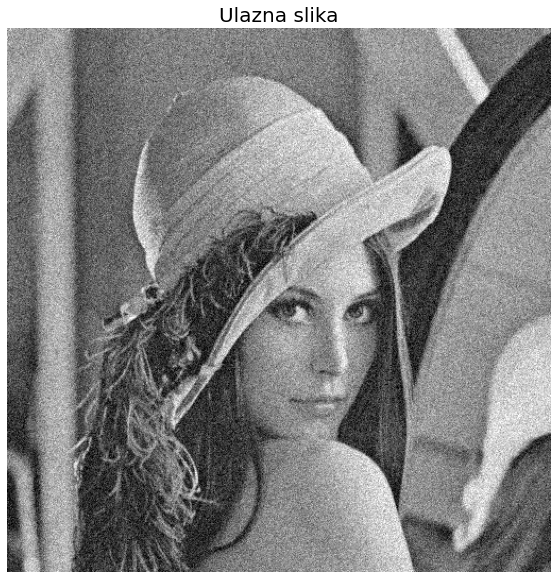

In [11]:
img = io.imread('sekvence/lena_noise.tif')

figsize = (10, 10)
fontsize = 20

plt.figure(figsize=figsize)
plt.imshow(img, cmap='gray')

plt.title('Ulazna slika', fontsize=fontsize)
plt.axis('off')
plt.show()

Parametri filtra

In [12]:
r = 30
sigma = r/3

Gauov filtar implementiran u prostornom domenu sa složenošću $\mathcal{O}(r)$

In [13]:
# r
start_time = time.time()

img_filtered_lin = filter_gauss(img, r, sigma)

print("lin --- %s seconds ---" % (time.time() - start_time))

lin --- 0.029916048049926758 seconds ---


Gauov filtar implementiran u prostornom domenu sa složenošću $\mathcal{O}(r^2)$

In [14]:
# r^2
start_time = time.time()

img_filtered_r2 = filter_gauss_r2(img, r, sigma)

print("r2 --- %s seconds ---" % (time.time() - start_time))

r2 --- 0.5575647354125977 seconds ---


Gausov filtar implementiran u frekvencijskom domenu sa složenošću $\mathcal{O}(1)$ u odnosu na $r$

In [15]:
# fft
start_time = time.time()

img_filtered_freq = filter_gauss_freq(img, r, sigma)

print("fft --- %s seconds ---" % (time.time() - start_time))

fft --- 0.045408010482788086 seconds ---


Gausov filtar implementiran u frekvencijskom domenu sa simetričnim proširivanjem slike

In [16]:
# fft ogledalo
start_time = time.time()

img_filtered_freq_prosireno = filter_gauss_freq_prosirivanje(img, r, sigma)

print("freq prosireno --- %s seconds ---" % (time.time() - start_time))

freq prosireno --- 0.17875242233276367 seconds ---


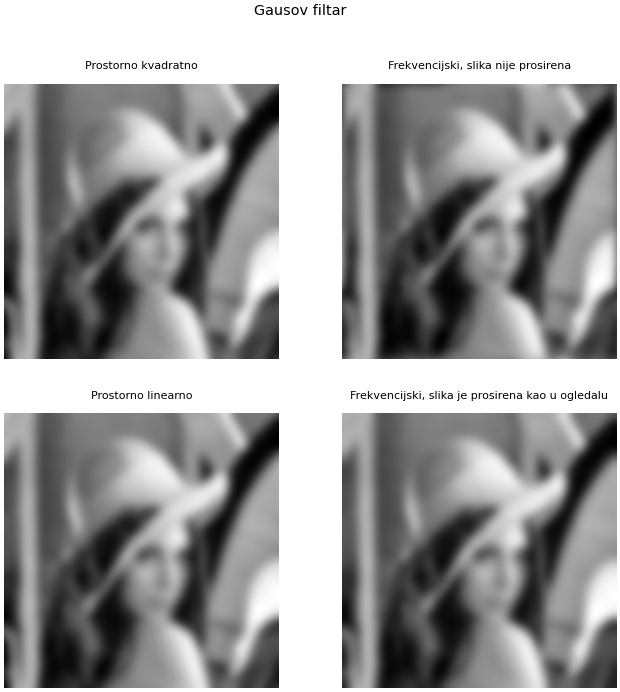

In [17]:
subplot_figsize = (20,20)
fig, ax = plt.subplots(2, 2, figsize=subplot_figsize, dpi=40);

suptitle_scale = 1.3

ax[0, 0].imshow(img_filtered_r2, cmap='gray')
ax[0, 0].set_title("Prostorno kvadratno\n", fontsize=fontsize)
ax[0, 0].axis('off')

ax[0, 1].imshow(img_filtered_freq, cmap='gray')
ax[0, 1].set_title("Frekvencijski, slika nije prosirena\n", fontsize=fontsize)
ax[0, 1].axis('off')

ax[1, 0].imshow(img_filtered_lin, cmap='gray')
ax[1, 0].set_title("Prostorno linearno\n", fontsize=fontsize)
ax[1, 0].axis('off')

ax[1, 1].imshow(img_filtered_freq_prosireno, cmap='gray')
ax[1, 1].set_title("Frekvencijski, slika je prosirena kao u ogledalu\n", fontsize=fontsize)
ax[1, 1].axis('off')

fig.suptitle("Gausov filtar", fontsize= suptitle_scale * fontsize)
plt.show()


Proširivanje kao u ogledalu očigledno rešava problem tamnih ivica koji se javlja kada ne proširujemo jer tada algoritam podrazumeva da je slika proširena nulama.

### Poređenje brzina izvršavanja

In [18]:
r_array = np.arange(1, 51)
t_spatial = np.zeros_like(r_array, dtype=np.float32)
t_freq = np.zeros_like(r_array, dtype=np.float32)

# freq prosiren nulama
for i in range(len(r_array)):
    start_time = time.time()
    filter_gauss_freq(img, r_array[i], r_array[i] / 3)
    end_time = time.time()
    t_freq[i] = end_time - start_time
    
    clear_output(wait=True)
    print("%3.0f" % ((i + 1)/len(r_array) * 100), " %")
    
# prostorni lin
for i in range(len(r_array)):
    start_time = time.time()
    filter_gauss(img, r_array[i], r_array[i] / 3)
    end_time = time.time()
    t_spatial[i] = end_time - start_time
    
    clear_output(wait=True)
    print("%3.0f" % ((i + 1)/len(r_array) * 100), " %")

100  %


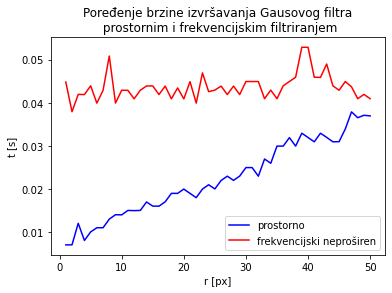

In [19]:
plt.figure()
plt.plot(r_array, t_spatial, label='prostorno', color='blue')
plt.plot(r_array, t_freq, label='frekvencijski neproširen', color='red')

plt.title("Poređenje brzine izvršavanja Gausovog filtra\n prostornim i frekvencijskim filtriranjem")
plt.xlabel('r [px]')
plt.ylabel('t [s]')
plt.legend()
plt.show()

Kako je složenost funkcije u frekvencijskom domenu konstantna u odnosu na radijus filtra, za razliku od funkcije u prostornom domenu čija je složenost linearna, ima smisla koristiti frekvencijski domen za velike prostorne maske, a prostorni domen za male.

In [20]:
t_spatial_r2 = np.zeros_like(r_array, dtype=np.float32)
t_freq_prosireno = np.zeros_like(r_array, dtype=np.float32)

# freq prosiren u ogledalu
for i in range(len(r_array)):
    start_time = time.time()
    filter_gauss_freq_prosirivanje(img, r_array[i], r_array[i] / 3)
    end_time = time.time()
    t_freq_prosireno[i] = end_time - start_time
    
    clear_output(wait=True)
    print("%3.0f" % ((i + 1)/len(r_array) * 100), " %")
    
# prostorni r2
for i in range(len(r_array)):
    start_time = time.time()
    filter_gauss_r2(img, r_array[i], r_array[i] / 3)
    end_time = time.time()
    t_spatial_r2[i] = end_time - start_time
    
    clear_output(wait=True)
    print("%3.0f" % ((i + 1)/len(r_array) * 100), " %")

100  %


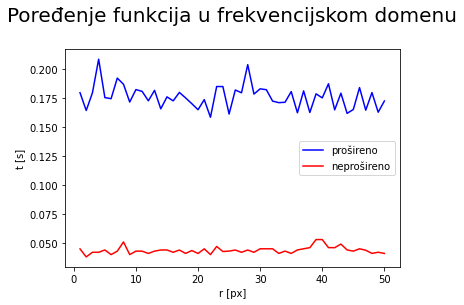

In [21]:
plt.figure()

plt.plot(r_array, t_freq_prosireno, label='prošireno', color='blue')
plt.plot(r_array, t_freq, label='neprošireno', color='red')
plt.title("Poređenje funkcija u frekvencijskom domenu\n", fontsize=fontsize)
plt.xlabel('r [px]')
plt.ylabel('t [s]')
plt.axis('on')
plt.legend()
plt.show()

Iako je filtriranje u frekvencijskom domenu nezavisno od $r$, vreme izvršavanje je ipak proporcionalno proizvodu širine i visine slike. Kako pri proširivanu dobijamo dva puta širu i dva puta višu sliku, tako je i vreme izvršavanja oko četiri puta veće i to je cena koju plaćamo kako ne bismo imali tamnije ivice posle filtriranja slike.

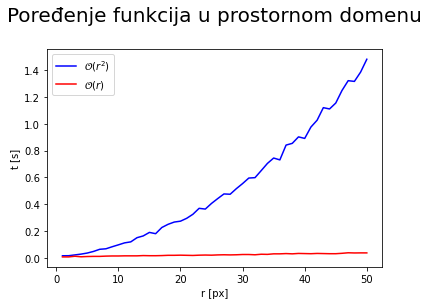

In [22]:
plt.figure()

plt.plot(r_array, t_spatial_r2, label='$\mathcal{O}(r^2)$', color='blue')
plt.plot(r_array, t_spatial, label='$\mathcal{O}(r)$', color='red')
plt.title("Poređenje funkcija u prostornom domenu\n", fontsize=fontsize)
plt.xlabel('r [px]')
plt.ylabel('t [s]')
plt.axis('on')
plt.legend()
plt.show()

Na poslednjoj slici vidimo značaj separabilnosti po dimenzijama prostornog kernela Gausovog filtra. 

Apdejtovanje numerisanja jednačina

In [26]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>